# Train model for all glaciers, random k-fold cv


In [6]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import xgboost as xgb

from model_functions import select_variables
from model_functions import train_xgb_model
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_fold

In [2]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-06-27_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_all = data[data['balance_netto'].notna()]
glacier_data_all.reset_index(drop=True, inplace=True)


### Using the same test glaciers as in "train_model_blocking_by_glacier"

In [4]:
# Manually select test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2768, 2478, 2769, 3127, 3141]

df_test = glacier_data_all[glacier_data_all['BREID'].isin(test_glaciers)]
# 54 has 37 points
# 703 has 13 points
# 1280 has 25 points
# 2478 has 22 points
# 2769 has 10 points
# 3127 has 60 points
# test has 323 points in total

df_train = glacier_data_all[~glacier_data_all['BREID'].isin(test_glaciers)]

# Training with random 5-fold cv with temperature and precipitation

In [30]:
# Select features
base_cols = ['altitude','aspect','slope','altitude_climate']
temp_cols = ['t2m_oct','t2m_nov','t2m_des','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_des','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['balance_netto']

In [31]:
# Select features for training
df_train_X = select_variables(df_train, base_cols, temp_cols, prec_cols)

# Select labels for training
df_train_y = select_variables(df_train, label_cols)

X_train, y_train = df_train_X.values, df_train_y.values

In [32]:
# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=5)
splits = list(kf.split(X_train, y_train))

### Train model

In [33]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -0.3715558775775474
Grid search best hyperparameters:  {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 400}
Cross validation scores per fold:  [-0.33115251 -0.39849525 -0.38539212 -0.42220311 -0.3205364 ]
Mean cross validation score:  -0.3715558775775474
Standard deviation:  0.03928799614858994


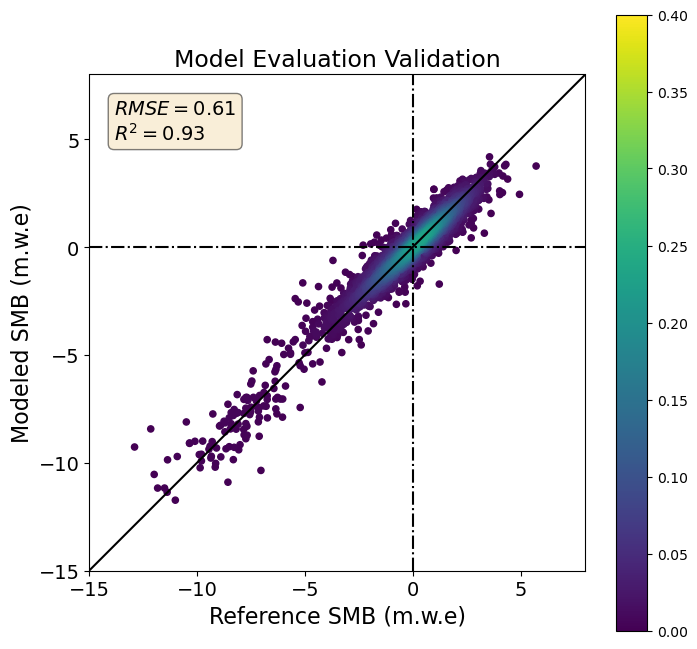

In [34]:
# Train model
cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, scorer='neg_mean_squared_error')

In [39]:
# Save model
import joblib

# Save cv-object
joblib.dump(cv_grid, 'Models/cv_random_5fold_temp_prec.pkl')
## joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

['Models/cv_random_5fold_temp_prec.pkl']

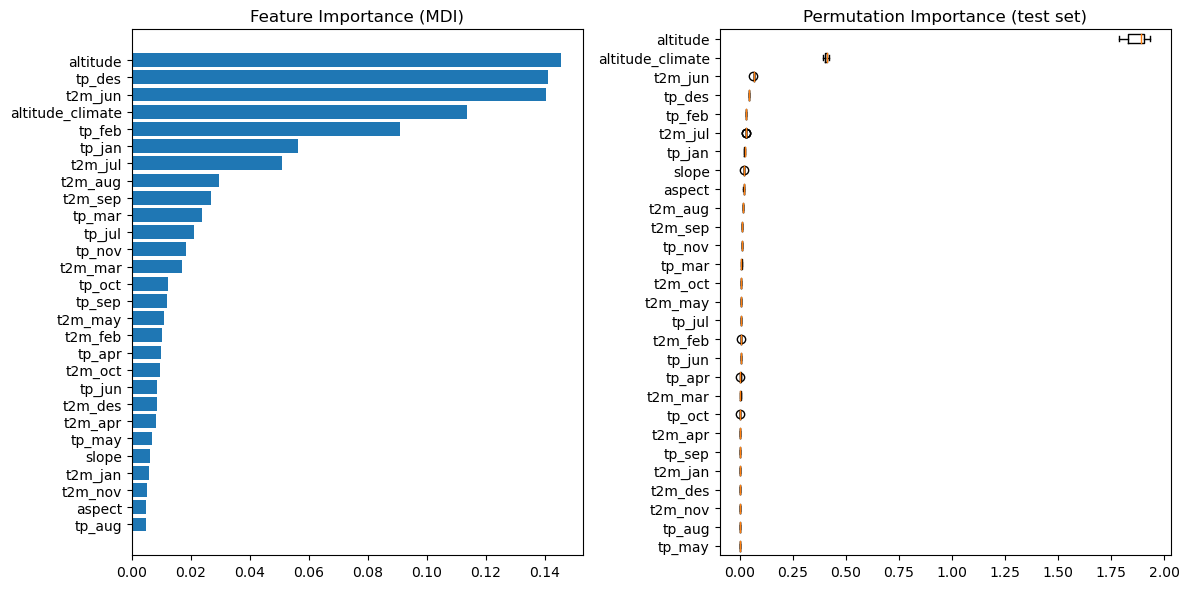

In [38]:
from sklearn.inspection import permutation_importance

best_model.fit(X_train, y_train)
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    best_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df_train_X.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Training with random 5-fold cv with all climate features

### Select features and prepare data for training

In [8]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat','lon','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_des','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_des','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_des','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation] for y in x]

df_train_X = df_train.drop(drop_cols, axis=1)
df_train_y = df_train[['balance_netto']]

X_train, y_train = df_train_X.values, df_train_y.values

In [9]:
# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=5)
splits = list(kf.split(X_train, y_train))

### Explore folds

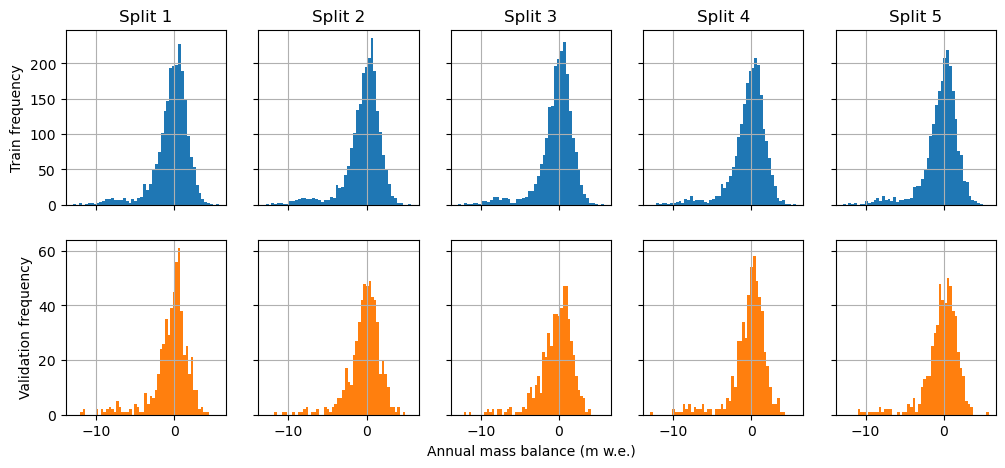

In [10]:
# Plot mass balance distributions of training and validation sets.
j=0
f, ax = plt.subplots(2, len(splits), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits)):
    if i>2:
        j=1
    df_train.iloc[splits[i][0]].balance_netto.plot.hist(bins=50, ax=ax[0,i], color='C0')
    df_train.iloc[splits[i][1]].balance_netto.plot.hist(bins=50, ax=ax[1,i], color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Validation frequency')
ax[1,2].set_xlabel('Annual mass balance (m w.e.)')
    
for row in ax:
    for a in row:
        a.grid()

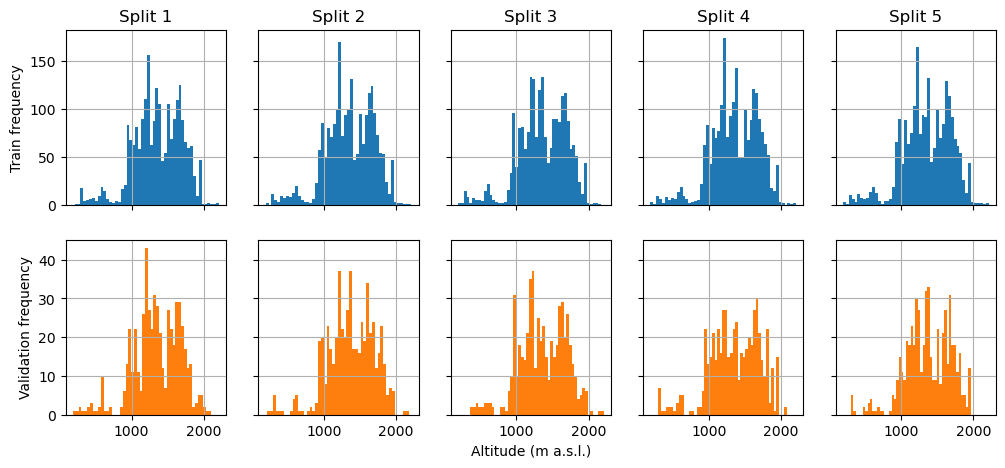

In [12]:
# Plot altitude distributions of training and validation sets.

j=0
f, ax = plt.subplots(2, len(splits), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits)):
    if i>2:
        j=1
    df_train.iloc[splits[i][0]].altitude.plot.hist(bins=50, ax=ax[0,i], color='C0')
    df_train.iloc[splits[i][1]].altitude.plot.hist(bins=50, ax=ax[1,i], color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Validation frequency')
ax[1,2].set_xlabel('Altitude (m a.s.l.)')
    
for row in ax:
    for a in row:
        a.grid()

### Train model

In [13]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -0.36315094420189814
Grid search best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400}
Cross validation scores per fold:  [-0.3136828  -0.33877869 -0.38795517 -0.42564586 -0.34969221]
Mean cross validation score:  -0.36315094420189814
Standard deviation:  0.03935252342362791


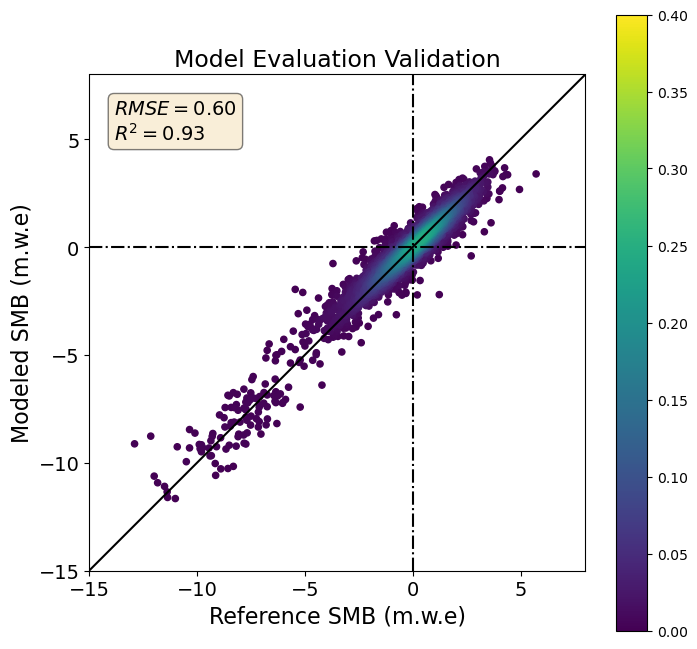

In [15]:
# Train model
cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, scorer='neg_mean_squared_error')

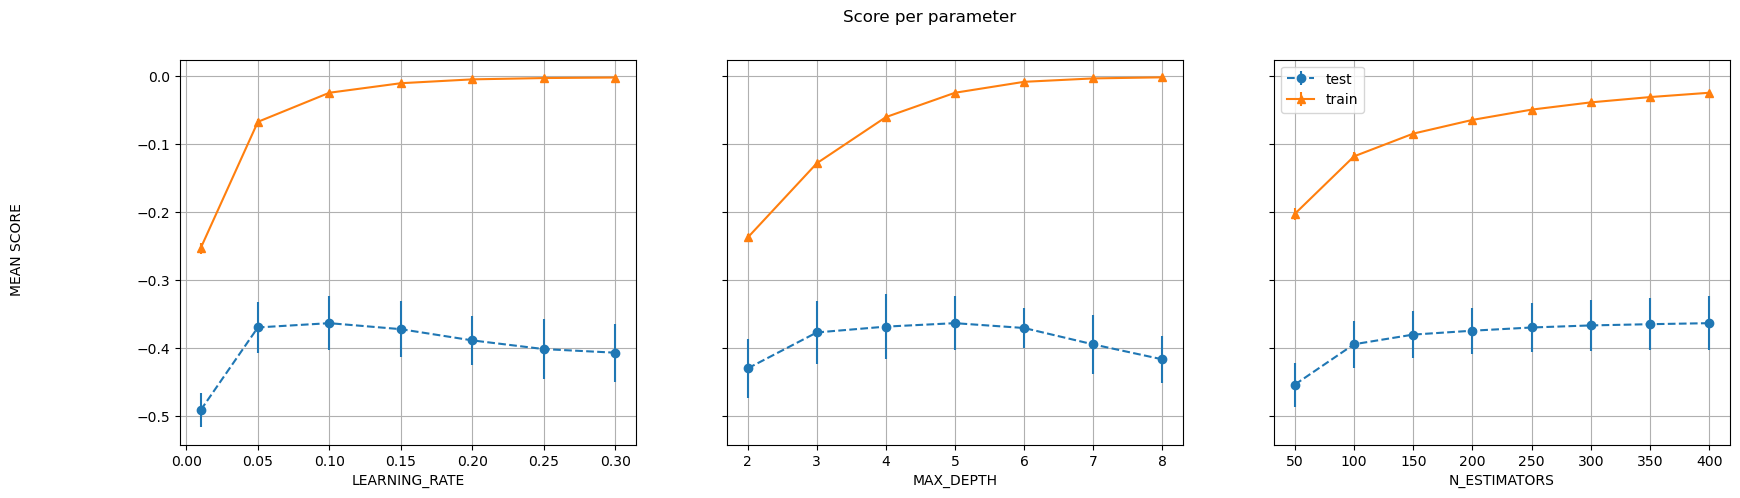

In [16]:
plot_gsearch_results(cv_grid)

In [17]:
# Save model
import joblib

# Save cv-object
joblib.dump(cv_grid, 'Models/cv_random_5fold_all_climate.pkl')
## joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

['Models/cv_random_5fold_all_climate.pkl']

In [20]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train, y_train)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X.columns)[ind]

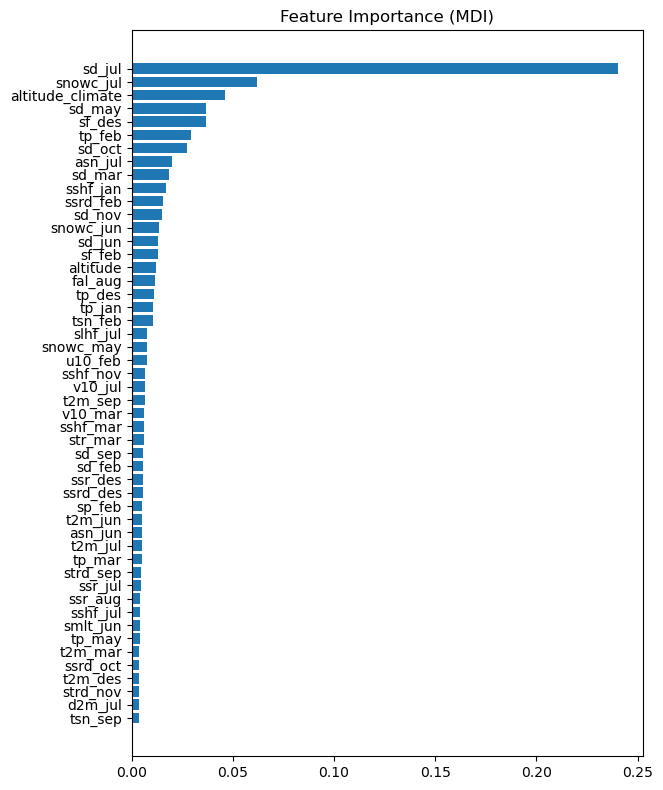

In [21]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Training with random 5-fold cv with minimal climate features (removing derived/redundant features)

### Select features and prepare data for training

In [47]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat','lon','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_des','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_des','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_des','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_des','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_des','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_des','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_des','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_des','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_des','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo] for y in x]

df_train_X = df_train.drop(drop_cols, axis=1)
df_train_y = df_train[['balance_netto']]

X_train, y_train = df_train_X.values, df_train_y.values

In [48]:
# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=5)
splits = list(kf.split(X_train, y_train))

### Train model

In [42]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
              'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
              'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
Cross validation score:  -0.3715558775775474
Grid search best hyperparameters:  {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 400}
Cross validation scores per fold:  [-0.33115251 -0.39849525 -0.38539212 -0.42220311 -0.3205364 ]
Mean cross validation score:  -0.3715558775775474
Standard deviation:  0.03928799614858994


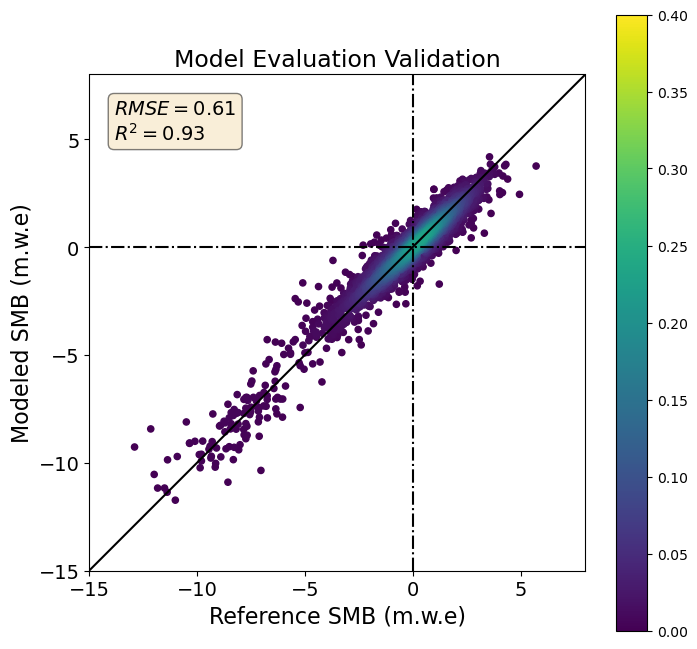

In [43]:
# Train model
cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, scorer='neg_mean_squared_error')

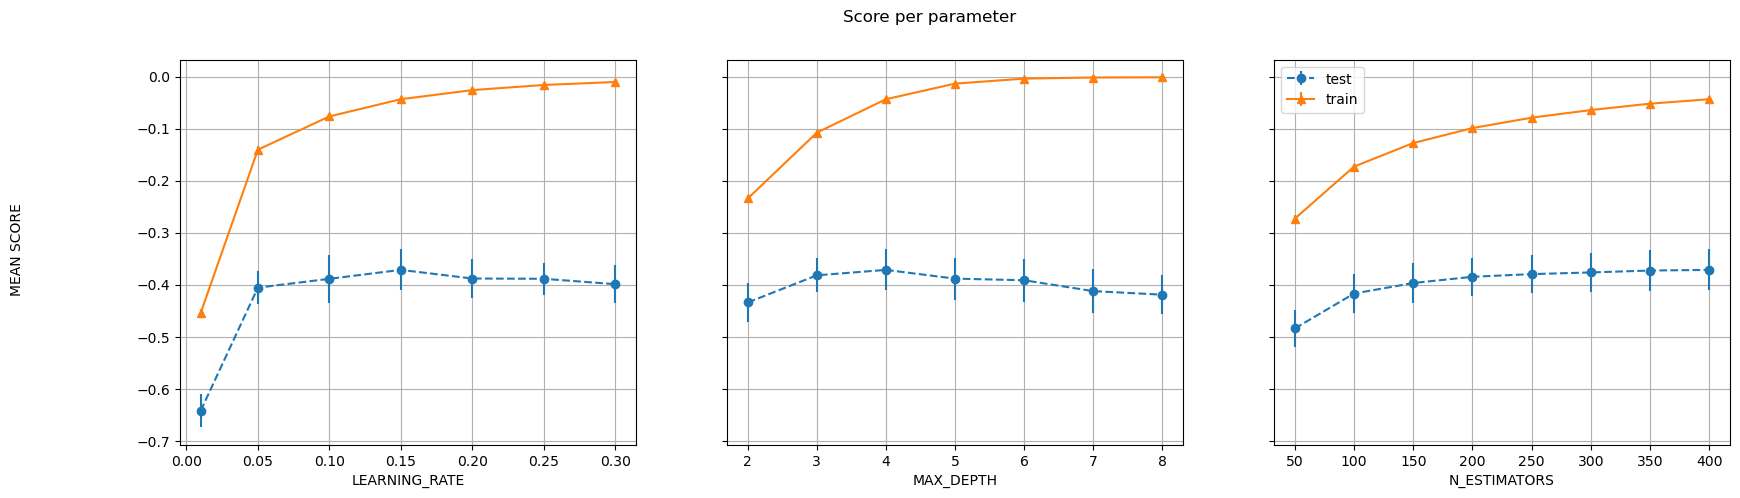

In [44]:
plot_gsearch_results(cv_grid)

In [45]:
# Save model
import joblib

# Save cv-object
joblib.dump(cv_grid, 'Models/cv_random_5fold_minimal_climate.pkl')
## joblib.load('/Models/cv_block_glacier_5fold_all_climate.pkl')

['Models/cv_random_5fold_minimal_climate.pkl']

In [46]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train, y_train)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X.columns)[ind]

ValueError: kth(=-22) out of bounds (28)